## Language translation with Torchtext!! ## 

Seq2Seq network with torchtext

https://pytorch.org/tutorials/beginner/torchtext_translation.html

In [1]:
import random
from typing import Tuple
import numpy as np
import torchtext
import torch
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
from torchtext.utils import download_from_url, extract_archive
import io
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
import math
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
url_base = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'
train_urls = ('train.de.gz', 'train.en.gz')
val_urls = ('val.de.gz', 'val.en.gz')
test_urls = ('test_2016_flickr.de.gz', 'test_2016_flickr.en.gz')

train_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in train_urls]
val_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in val_urls]
test_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in test_urls]

de_tokenizer = get_tokenizer(tokenizer=None) #'spacy', language='de')
en_tokenizer = get_tokenizer(tokenizer=None) #'spacy', language='en')

def build_vocab(filepath, tokenizer):
    counter = Counter()
    with io.open(filepath, encoding="utf8") as f:
        for string_ in f:
            counter.update(tokenizer(string_))
    
    return Vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

de_vocab = build_vocab(train_filepaths[0], de_tokenizer)
en_vocab = build_vocab(train_filepaths[1], en_tokenizer)

def data_process(filepaths):
    raw_de_iter = iter(io.open(filepaths[0], encoding="utf8"))
    raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
    src_max_length = 0
    tgt_max_length = 0
    data = []
    for (raw_de, raw_en) in zip(raw_de_iter, raw_en_iter):
        de_tensor_ = torch.tensor([de_vocab[token] for token in de_tokenizer(raw_de)], dtype=torch.long)
        en_tensor_ = torch.tensor([en_vocab[token] for token in en_tokenizer(raw_en)], dtype=torch.long)
        data.append((de_tensor_, en_tensor_))
        
        if de_tensor_.size(0) > src_max_length:
            src_max_length = de_tensor_.size(0)
            
        if en_tensor_.size(0) > tgt_max_length:
            tgt_max_length = en_tensor_.size(0)
        
    return data, src_max_length, tgt_max_length

train_data, trsl, trtl = data_process(train_filepaths)
val_data, vsl, vtl = data_process(val_filepaths)
test_data, tesl, tetl = data_process(test_filepaths)

In [3]:
# We calculate the sentence with max_length
candidates_lengths = [trsl, trtl, vsl, vtl, tesl, tetl]
print(max(candidates_lengths))
MAX_LENGTH = max(candidates_lengths) + 2
print(MAX_LENGTH)

39
41


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
BATCH_SIZE = 128
PAD_IDX = de_vocab['<pad>']
BOS_IDX = de_vocab['<bos>']
EOS_IDX = de_vocab['<eos>']

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def generate_batch(data_batch):
    de_batch, en_batch, en_batch_out = [], [], []
    a = 0
    for (de_item, en_item) in data_batch:
        de_extra = MAX_LENGTH - (de_item.size(0) + 2)
        en_extra = MAX_LENGTH - (en_item.size(0) + 2)
        en_inp_extra = MAX_LENGTH - (en_item.size(0) + 1)
        
        de_batch.append(torch.cat([torch.tensor([BOS_IDX]), de_item, torch.tensor([EOS_IDX]), torch.full((de_extra,), PAD_IDX)], dim=0))
        en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX]), torch.full((en_extra,), PAD_IDX)], dim=0))
        en_batch_out.append(torch.cat([en_item, torch.tensor([EOS_IDX]), torch.full((en_inp_extra,), PAD_IDX)], dim=0)) # Target input 
    de_batch = pad_sequence(de_batch, padding_value=PAD_IDX)
    en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)
    en_batch_out = pad_sequence(en_batch_out, padding_value=PAD_IDX)
    return de_batch, en_batch, en_batch_out

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)

In [6]:
german_id_to_text = lambda x: [de_vocab.itos[t] for t in x]

In [7]:
english_id_to_text = lambda x: [en_vocab.itos[t] for t in x]

## Now, we create the Seq2Seq model ##

The Seq2Seq model is an encoder-decoder model

In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string <SOS> token, and the first hidden state is the context vector (the encoder’s last hidden state).

In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, gru_layers):
        super(EncoderRNN, self).__init__()
        self.gru_layers = gru_layers
        
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, gru_layers)

    def forward(self, x, hidden):
        batch_size = x.size()[0]
#         print("X :", x.shape)
        embedded = self.embedding(x)
#         print("EMBEDD: ", embedded.shape)
        embedded = embedded.view(1, batch_size, -1)
#         print("EMBEDD VIEW: ", embedded.shape)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(self.gru_layers, batch_size, self.hidden_size, device=device)

### Attention Decoder ###
If only the context vector is passed betweeen the encoder and decoder, that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs. First we calculate a set of attention weights. These will be multiplied by the encoder output vectors to create a weighted combination. The result (called attn_applied in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

Calculating the attention weights is done with another feed-forward layer attn, using the decoder’s input and hidden state as inputs. Because there are sentences of all sizes in the training data, to actually create and train this layer we have to choose a maximum sentence length (input length, for encoder outputs) that it can apply to. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few

In [9]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, gru_layers, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.gru_layers = gru_layers

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, gru_layers)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x, hidden, encoder_outputs):
        batch_size = x.size()[0]
        # Embedding: a simple lookup table that stores embeddings of a fixed dictionary and size.
        # This module is often used to store word embeddings and retrieve them using indices. 
        # The input to the module is a list of indices, and the output is the corresponding word embeddings
#         print("INPUT SHAPE: ", x.shape)
#         print(batch_size)
        embedded = self.embedding(x)
#         print("EMBEDD: ", embedded.shape)
        embedded = embedded.view(1, batch_size, -1)
#         print("EMBEDD VIEW: ", embedded.shape)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        
        # torch.bmm performs a batch matrix-matrix product of matrices stored in input and mat2.
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self, batch_size):
        return torch.zeros(self.gru_layers, batch_size, self.hidden_size, device=device)

### We  create the classic train/evaluate loop ###

For this task, we have something called **teacher_forcing_ratio**, this helps us vary between giving the network the possibility to try to translate using its own previous prediction (no teacher forcing), or we use the known target for it

In [10]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, target_tensor_out, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):

    encoder_hidden = encoder.initHidden(input_tensor.size(1))
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)

    loss = 0
    
    # We run the input sequence through the encoder
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
#         print(encoder_output.shape)
        encoder_outputs[ei] = encoder_output[0, 0]
    
    decoder_input = torch.full((target_tensor.size(1),), BOS_IDX, device=device)
#     decoder_input = torch.tensor([[BOS_IDX], target_tensor.size(1)], device=device)

#     print(decoder_input.shape)
    decoder_hidden = encoder_hidden
    decoded_words = []
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoded_words.append(english_id_to_text(topi[0]))
            loss += criterion(decoder_output, target_tensor_out[di])
            if di + 1 < target_length:
                decoder_input = target_tensor[di + 1]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoded_words.append(english_id_to_text(topi[0]))
            decoder_input = topi.detach()  # detach from history as input
#             print(target_tensor[di].shape)
            loss += criterion(decoder_output, target_tensor_out[di])

#     print(decoded_words)
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [11]:
def evaluate(encoder, decoder, input_tensor):
    with torch.no_grad():
        input_tensor = input_tensor.to(device)
        encoder_hidden = encoder.initHidden(input_tensor.size(1))
        input_length = input_tensor.size(0)

        encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)
        
        # We run the input sequence through the encoder
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]
        
#         print(encoder_outputs[:1])
        decoder_input = torch.full((input_tensor.size(1),), BOS_IDX, device=device)
        decoder_hidden = encoder_hidden
        
        decoded_words = []
        decoder_attentions = torch.zeros(MAX_LENGTH, MAX_LENGTH)

        for di in range(MAX_LENGTH):
#             print(decoder_input)
#             print(decoder_input.shape)
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.topk(1)
            if topi.item() == EOS_IDX:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(english_id_to_text(topi))
#             print(decoded_words)
            decoder_input = topi.detach()
          
        return decoded_words, decoder_attentions[:di + 1]

In [12]:
# Helper methods
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s' % (asMinutes(s))

In [13]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [14]:
def trainIters(encoder, decoder, epochs, print_every=50, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    PAD_IDX = en_vocab.stoi['<pad>']
    criterion = nn.NLLLoss(ignore_index=PAD_IDX)

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    for epoch in range(0, epochs +1):
        print_loss_total = 0  # Reset every print_every
        plot_loss_total = 0  # Reset every plot_every
        print("-----------------------")
        print("EPOCH: ", epoch, " out of ", epochs, " epochs")
        print("-----------------------")
        for batch_counter, (src, trg, trg_output) in enumerate(train_iter):
            src, trg, trg_output = src.to(device), trg.to(device), trg_output.to(device)
            src_ = src.permute(1,0)
            trg_ = trg.permute(1,0)
            trg_output_ = trg_output.permute(1, 0)
            
            # Uncomment to go 1 by 1 manual unbatch version (preferably simply set batch = 1)
#             for j in range(len(src_)):
#                 loss = train(src_[j].unsqueeze(dim=1), trg_[j].unsqueeze(dim=1), trg_output_[j].unsqueeze(dim=1), encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
#                 print_loss_total += loss
#                 plot_loss_total += loss
                
            loss = train(src, trg, trg_output, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
            print_loss_total += loss
            plot_loss_total += loss

    #     training_pairs = [tensorsFromPair(random.choice(pairs))
    #                       for i in range(n_iters)]

            batch_counter += 1

            if batch_counter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (timeSince(start, batch_counter / len(train_iter)),
                                             batch_counter, batch_counter/ len(train_iter) * 100, print_loss_avg))

            if batch_counter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0

    showPlot(plot_losses)

The model has 7,951,616 trainable parameters
The model has 9,662,349 trainable parameters
-----------------------
EPOCH:  0  out of  1  epochs
-----------------------
0m 11s (50 22%) 5.2251
0m 23s (100 44%) 4.2727
0m 35s (150 66%) 3.9138
0m 47s (200 88%) 3.8743
-----------------------
EPOCH:  1  out of  1  epochs
-----------------------
1m 4s (50 22%) 3.7265
1m 16s (100 44%) 3.7429
1m 27s (150 66%) 3.9775
1m 38s (200 88%) 3.6867


<Figure size 432x288 with 0 Axes>

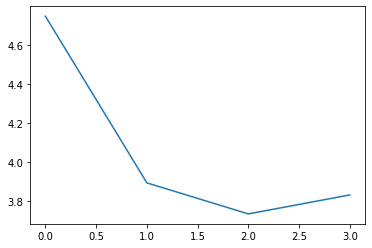

In [15]:
INPUT_DIM = len(de_vocab)
OUTPUT_DIM = len(en_vocab)
hidden_size = 256

encoder1 = EncoderRNN(INPUT_DIM, hidden_size, 4).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, OUTPUT_DIM, 4, dropout_p=0.1).to(device)

def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(encoder1):,} trainable parameters')
print(f'The model has {count_parameters(attn_decoder1):,} trainable parameters')

trainIters(encoder1, attn_decoder1, epochs = 1, print_every=50)

In [16]:
# Randomly evaluate
def evaluateRandomly(encoder, decoder, n=10):
    for _, (src, trg, tgt_output) in enumerate(test_iter):
        for i in range(n):
#             print(src.shape)
            src_ = src.permute(1,0)
            trg_ = trg.permute(1,0)
#             print(src_[i])
#             print(src_[i].unsqueeze(dim=1).shape)

            src_ = src_[i]
            trg_ = trg_[i]
            print('>', german_id_to_text(src_))
            print('=', english_id_to_text(trg_))
            output_words, attentions = evaluate(encoder, decoder, src_.unsqueeze(dim=1))
#             output_sentence = ' '.join(output_words)
            print('<', output_words)
            print('')
        break

In [17]:
evaluateRandomly(encoder1, attn_decoder1, 1)

> ['<bos>', 'Ein', 'Mann', 'auf', 'einem', 'Motorrad', 'zeigt', 'einen', 'Trick', 'auf', 'einer', 'Rennstrecke.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
= ['<bos>', 'A', 'man', 'riding', 'a', 'motorcycle', 'is', 'performing', 'a', 'trick', 'at', 'a', 'track.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
< [['A'], ['man'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], [

## Machine Translation is hard task!!
For this work: https://pytorch.org/tutorials/beginner/translation_transformer.html

Training duration is quite long, as well as the dataset is no sufficient for machine translation network. However, in this case it is enough in order to under stand the purpose and learn the new techniques.

Implement and test Pytorch’s own Transformer models for machine translation
Analyze based on the output and measurements.
Compare to provided example seq2seq

# Lab Assignment Below:

In [18]:
from torch.nn import (TransformerEncoder, TransformerDecoder,
                      TransformerEncoderLayer, TransformerDecoderLayer)

class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers: int, num_decoder_layers: int,
                 emb_size: int, src_vocab_size: int, tgt_vocab_size: int,
                 dim_feedforward:int = 512, dropout:float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        encoder_layer = TransformerEncoderLayer(d_model=emb_size, nhead=NHEAD,
                                                dim_feedforward=dim_feedforward)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        decoder_layer = TransformerDecoderLayer(d_model=emb_size, nhead=NHEAD,
                                                dim_feedforward=dim_feedforward)
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self, src: Tensor, trg: Tensor, src_mask: Tensor,
                tgt_mask: Tensor, src_padding_mask: Tensor,
                tgt_padding_mask: Tensor, memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        memory = self.transformer_encoder(src_emb, src_mask, src_padding_mask)
        outs = self.transformer_decoder(tgt_emb, memory, tgt_mask, None,
                                        tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer_encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer_decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [19]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding +
                            self.pos_embedding[:token_embedding.size(0),:])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [20]:
# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [21]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [22]:
# Define the parameters of our model and instantiate it.
# Define loss function and optimizer - Train model further down.
SRC_VOCAB_SIZE = len(de_vocab)
TGT_VOCAB_SIZE = len(en_vocab)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
NUM_EPOCHS = 3 #not too many epochs

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device("cpu")
#print("device", DEVICE)
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS,
                                 EMB_SIZE, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE,
                                 FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(
    transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9
)

In [23]:
def train_epoch(model, train_iter, optimizer,print_every=50, plot_every=100,):
    start_time = time.time()
    plot_losses = []
    model.train()
    losses = 0
    for idx, sample in enumerate(train_iter):
        #print("s", len(sample))
        print_loss_total = 0  # Reset every print_every
        plot_loss_total = 0  # Reset every plot_every

        src = sample[0]
        tgt = sample[1]
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,
                                src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:,:]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

        print_loss_total += loss
        plot_loss_total += loss

        if idx % print_every == 0:
            print_loss_avg = print_loss_total / BATCH_SIZE
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start_time, (idx+1) / len(train_iter)),
                                        idx, (idx+1)/ len(train_iter) * 100, print_loss_avg))

        if idx % plot_every == 0:
            plot_loss_avg = plot_loss_total / BATCH_SIZE
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    end_time = time.time()
    return losses / len(train_iter), plot_losses


def evaluate(model, val_iter):
    model.eval()
    losses = 0
    for idx, sample in (enumerate(valid_iter)):
       
        src = sample[0]
        tgt = sample[1]
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,
                                  src_padding_mask, tgt_padding_mask, src_padding_mask)
        tgt_out = tgt[1:,:]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()
    #print("s1", len(sample))
    return losses / len(val_iter)

In [24]:
for epoch in range(1, NUM_EPOCHS+1):
    print("-----------------------")
    print("EPOCH: ", epoch, " out of ", NUM_EPOCHS, " epochs")
    print("-----------------------")

    train_loss, plot_losses = train_epoch(transformer, train_iter, optimizer)
    val_loss = evaluate(transformer, valid_iter)
    #train_loss = train_epoch(transformer, optimizer)
    #val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}"))

#showPlot(plot_losses)

-----------------------
EPOCH:  1  out of  3  epochs
-----------------------
0m 0s (0 0%) 0.0759
0m 12s (50 22%) 0.0509
0m 24s (100 44%) 0.0430
0m 36s (150 66%) 0.0404
0m 48s (200 88%) 0.0373
Epoch: 1, Train loss: 5.865, Val loss: 4.564
-----------------------
EPOCH:  2  out of  3  epochs
-----------------------
0m 0s (0 0%) 0.0363
0m 12s (50 22%) 0.0345
0m 24s (100 44%) 0.0334
0m 36s (150 66%) 0.0333
0m 48s (200 88%) 0.0297
Epoch: 2, Train loss: 4.189, Val loss: 3.749
-----------------------
EPOCH:  3  out of  3  epochs
-----------------------
0m 0s (0 0%) 0.0302
0m 12s (50 22%) 0.0280
0m 24s (100 44%) 0.0267
0m 37s (150 66%) 0.0269
0m 49s (200 88%) 0.0273
Epoch: 3, Train loss: 3.561, Val loss: 3.347


In [25]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        memory_mask = torch.zeros(ys.shape[0], memory.shape[0]).to(device).type(torch.bool)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


def translate(model, src, src_vocab, tgt_vocab, src_tokenizer):
    model.eval()
    tokens = [BOS_IDX] + [src_vocab.stoi[tok] for tok in src_tokenizer(src)]+ [EOS_IDX]
    num_tokens = len(tokens)
    src = (torch.LongTensor(tokens).reshape(num_tokens, 1) )
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join([tgt_vocab.itos[tok] for tok in tgt_tokens]).replace("<bos>", "").replace("<eos>", "")

In [26]:
translate(transformer, "Eine Gruppe von Menschen steht vor einem Iglu .", de_vocab, en_vocab, de_tokenizer)

' A group of people standing in front of a building. '

# Lab Assignment Below
For this work: https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html
### Generating names

In [46]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker


In [47]:
def findFiles(path): return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('C:/Users/jason/Python/Jason/Done/2-language-models-lab/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal


In [48]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [49]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [50]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [51]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [52]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [53]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [54]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 80000
print_every = 10000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 16s (10000 12%) 2.8473
0m 32s (20000 25%) 2.8129
0m 48s (30000 37%) 1.9738
1m 4s (40000 50%) 2.3870
1m 20s (50000 62%) 1.6632
1m 36s (60000 75%) 3.0329
1m 52s (70000 87%) 1.8133
2m 8s (80000 100%) 1.5035


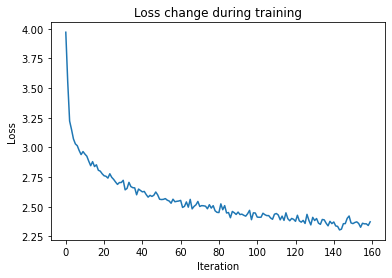

In [55]:
plt.figure()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title('Loss change during training')
plt.plot(all_losses)

In [56]:
name_length = 20

# Sample from a country/language and starting letter
def sample(language, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(language)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(name_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get several samples from one country/language
# and starting letters of each name
def samples(language, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(language, start_letter))
        
print("---------ENG---------")
samples('English','AJM')
print("---------RUS---------")
samples('Russian', 'RUS')
print("---------KOR---------")
samples('Korean', 'KLI')
print("---------GRE---------")
samples('Greek', 'GTS')
print("---------CHI---------")
samples('Chinese', 'CLH')

---------ENG---------
Aler
Jaller
Marta
---------RUS---------
Roullov
Uantan
Santov
---------KOR---------
Ka
Lo
Ion
---------GRE---------
Garisos
Tarisos
Sallas
---------CHI---------
Cha
Lan
Han
